In [1]:
import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

from pymfr.detect import detect_flux_ropes

In [2]:
time = ['2016-01-01T00:00:00Z', '2016-01-02T00:00:00Z']

file_name = f"./wind_{time[0]}_{time[1]}_60s.npz"
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('WI_H1_SWE', ['Proton_VX_moment', 'Proton_VY_moment', 'Proton_VZ_moment', 'Proton_Np_moment'], time[0], time[1])

    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)

    velocity = np.column_stack([data.Proton_VX_moment.values,
                                data.Proton_VY_moment.values,
                                data.Proton_VZ_moment.values])
    velocity[np.any(velocity == data.Proton_VX_moment.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VY_moment.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VZ_moment.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime)).interpolate()
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s").interpolate()
    times = velocity.index.values

    density = data.Proton_Np_moment.values
    density[density == data.Proton_Np_moment.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime)).interpolate()
    density = density.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    status, data = cdas.get_data('WI_H0_MFI', ['BGSE'], time[0], time[1])

    magnetic_field = data.BGSE.values
    magnetic_field[np.any(magnetic_field == data.BGSE.FILLVAL, axis=1), :] = np.nan
    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime)).interpolate()

    magnetic_field = magnetic_field.truncate(times[0], times[-1])
    density = density.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    velocity = velocity.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    times = magnetic_field.index.values

    assert len(magnetic_field) == len(velocity) == len(density)

    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
times = data["times"]

In [3]:
durations = range(10, 360)
results = detect_flux_ropes(magnetic_field, velocity, density,
                            batch_size_mb=4096,
                            window_steps=[max(duration // 32, 1) for duration in durations],
                            durations=durations, min_strength=5, frame_type="vht_2d")

100%|██████████| 350/350 [00:33<00:00, 10.58it/s]


2016-01-01T01:40:30.000000000  to  2016-01-01T01:49:30.000000000
duration: 10
error: 0.12 0.105
walen slope: -1.333
<B>: 13.83
Altitude/azimuth: 70 / 190


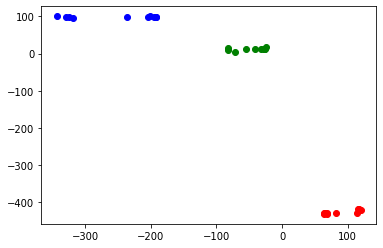

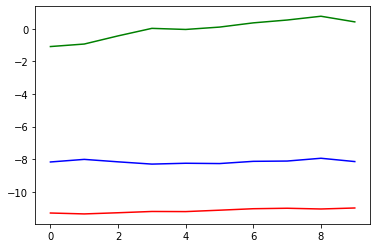

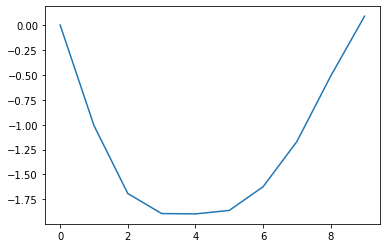

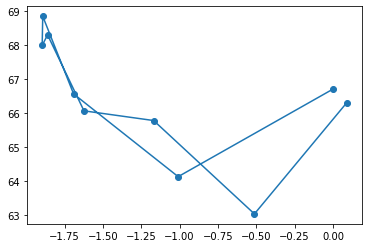

2016-01-01T05:10:30.000000000  to  2016-01-01T06:46:30.000000000
duration: 97
error: 0.103 0.1
walen slope: -1.136
<B>: 10.34
Altitude/azimuth: 55 / 120


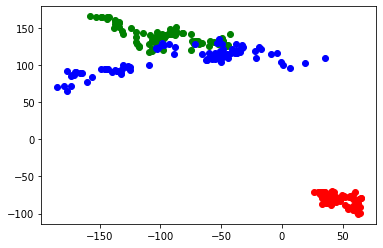

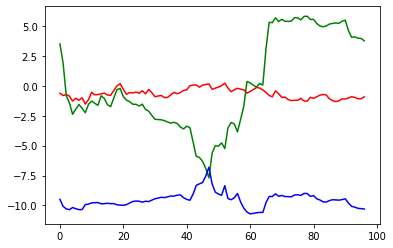

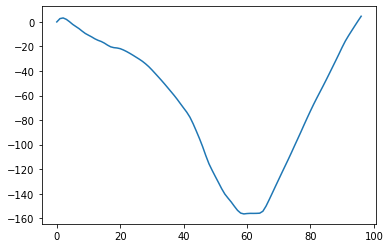

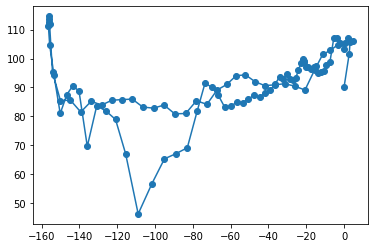

2016-01-01T07:50:30.000000000  to  2016-01-01T11:44:30.000000000
duration: 235
error: 0.12 0.119
walen slope: -0.504
<B>: 9.74
Altitude/azimuth: 85 / 280


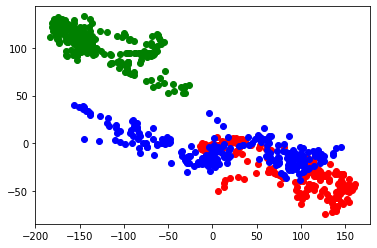

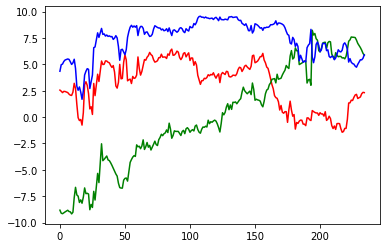

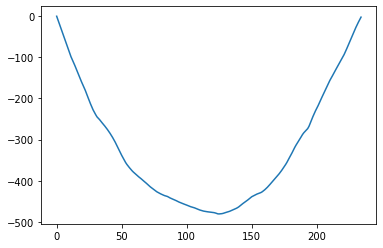

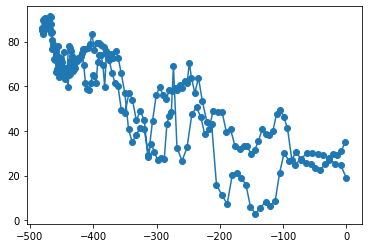

2016-01-01T11:53:30.000000000  to  2016-01-01T12:17:30.000000000
duration: 25
error: 0.084 0.065
walen slope: 0.322
<B>: 9.92
Altitude/azimuth: 75 / 60


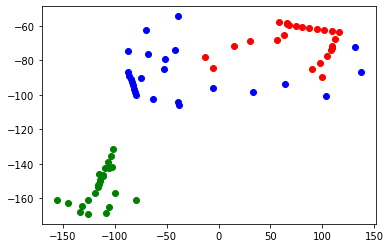

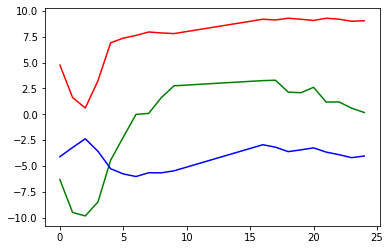

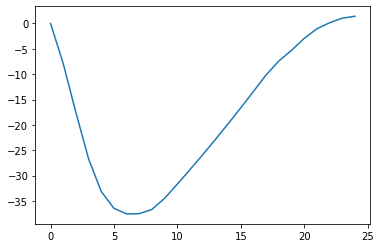

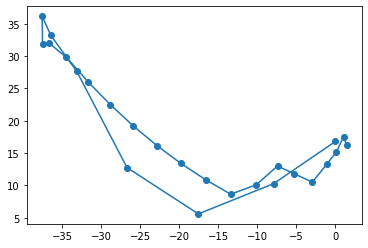

2016-01-01T13:23:30.000000000  to  2016-01-01T13:42:30.000000000
duration: 20
error: 0.1 0.128
walen slope: -0.031
<B>: 9.17
Altitude/azimuth: 85 / 60


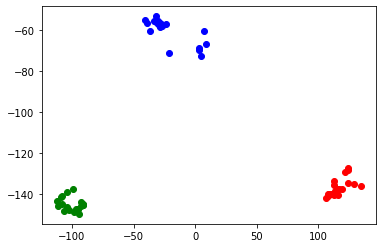

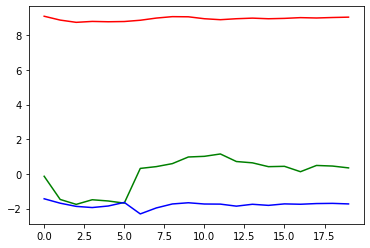

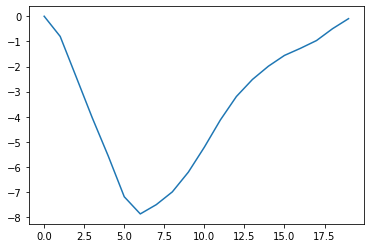

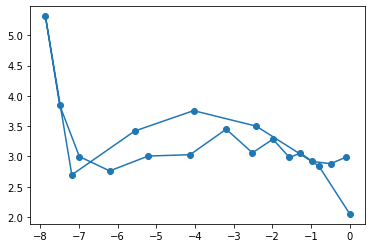

2016-01-01T14:49:30.000000000  to  2016-01-01T15:58:30.000000000
duration: 70
error: 0.118 0.105
walen slope: -2.388
<B>: 8.99
Altitude/azimuth: 85 / 320


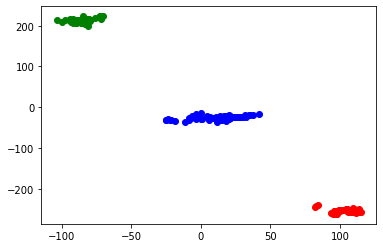

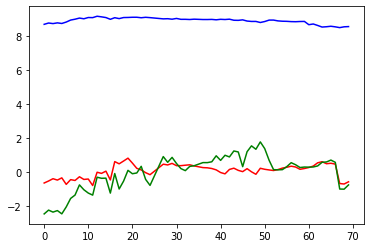

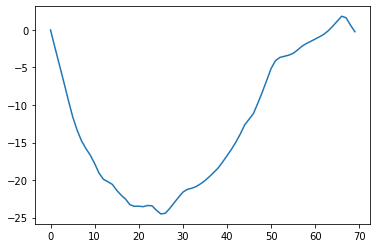

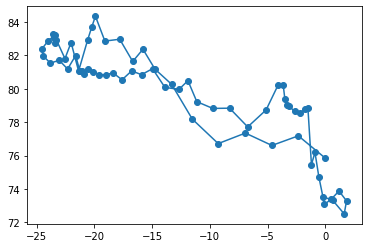

2016-01-01T18:09:30.000000000  to  2016-01-01T22:25:30.000000000
duration: 257
error: 0.119 0.126
walen slope: 1.223
<B>: 5.83
Altitude/azimuth: 80 / 240


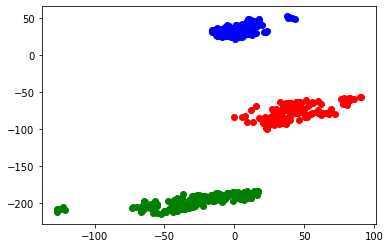

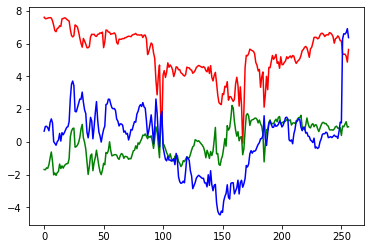

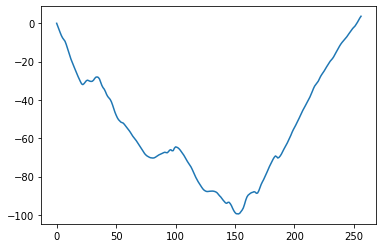

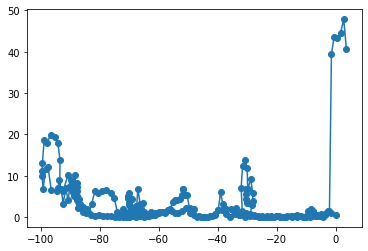

In [5]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


for residue, start, end, duration, axis, frame, error_fit in results:
    z_unit = np.array(axis)
    frame = np.array(frame)

    event_velocity = velocity[start:start + duration].cpu().numpy()
    event_field = magnetic_field[start:start + duration].cpu().numpy()

    x_unit = -(frame - np.dot(frame, z_unit) * z_unit)
    x_unit = x_unit / np.linalg.norm(x_unit)
    y_unit = np.cross(z_unit, x_unit)
    rotation_matrix = np.column_stack([x_unit, y_unit, z_unit])
    rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix

    event_density = density[start:start + duration].cpu().numpy()

    alfven_velocity = event_field / np.sqrt(scipy.constants.mu_0
                                            * scipy.constants.m_p
                                            * np.expand_dims(event_density, axis=1)) * 1e-15
    remaining_flow = event_velocity - frame

    d_flow = remaining_flow - remaining_flow.mean()
    d_alfven = alfven_velocity - alfven_velocity.mean()
    walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

    # if walen_slope > 0.3:
    #     continue

    print(times[start], " to ", times[end])
    print("duration:", duration)
    print("error:", round(residue, 3), round(error_fit, 3))
    print("walen slope:", round(walen_slope, 3))
    print("<B>:", round(np.linalg.norm(event_field, axis=1).mean(), 2))
    altitude, azimuth = spherical(*axis)
    print("Altitude/azimuth:", round(altitude), "/", round(azimuth % 360))

    colors = ["red", "green", "blue"]

    for i_color, color in enumerate(colors):
        plt.scatter(alfven_velocity[:, i_color], remaining_flow[:, i_color], color=color)
    plt.show()

    rotated = rotation_matrix @ event_field.T
    for i_color, color in enumerate(colors):
        plt.plot(rotated[i_color], color=color)
    plt.show()

    A = scipy.integrate.cumulative_trapezoid(rotated[1], initial=0)
    plt.plot(A)
    plt.show()

    P = rotated[2] ** 2
    plt.scatter(A, P)
    plt.plot(A, P)
    plt.show()